In [10]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import sys

from tqdm import tqdm


# **Import and Process Data**

In [11]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# labels not needed for autoencoders hence removing the first column
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = (data - np.mean(data)) / (np.max(data) - np.mean(data))

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# **Create the DL Model**

In [12]:
class aenet(nn.Module):
    def __init__(self,uEncoder, uLatent, uDecoder):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,uEncoder)

      ### encoder layer
      self.enc = nn.Linear(uEncoder,uLatent)

      ### latent layer
      self.lat = nn.Linear(uLatent,uDecoder)

      ### decoder layer
      self.dec = nn.Linear(uDecoder,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y

In [13]:
def createAEnet(uEncoder, uLatent, uDecoder):
   # create the model instance
  net = aenet(uEncoder, uLatent, uDecoder)

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [14]:
# test the model with a bit of data
net,lossfun,optimizer = createAEnet(250,50,250)

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


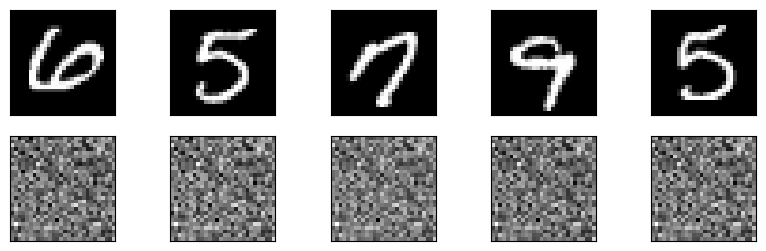

In [15]:
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.show();

# **Train the model**

In [16]:
# def trainAEnet(numepochs=50,uEncoder=250,uLatent=50,uDecoder=250):

#   #create a new model
#   net,lossfun,optimizer = createAEnet(uEncoder,uLatent,uDecoder)

#   #initialize losses
#   losses = []

#   # batch size and number of batches
#   batchsize  = 32
#   numBatches = int(dataT.shape[0]/batchsize)


#   # loop over epochs
#   for epochi in range(numepochs):

#     # get a permuted index vector
#     randidx = np.random.permutation(dataT.shape[0]).astype(int)

#     # losses during the batches
#     batchlosses = []

#     for batchi in range(numBatches):

#       # samples to use in this batch
#       samps2use = range((batchi-1)*batchsize,batchi*batchsize)

#       X = dataT[randidx,:]

#       # forward pass and loss
#       yHat = net(X)
#       loss = lossfun(yHat,X)

#       # backprop
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#       # losses in this batch
#       batchlosses.append( loss.item() )
#     # end minibatch loop

#     losses.append( np.mean(batchlosses[-3:]) )
#   # end epochs

#   # function output
#   return losses,net

In [17]:
def trainAEnet(numepochs=50, uEncoder=250, uLatent=50, uDecoder=250, device=None):
    net, lossfun, optimizer = createAEnet(uEncoder, uLatent, uDecoder)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    # assume dataT is a torch.Tensor [N, D]
    N = dataT.shape[0]
    batchsize  = 32
    numBatches = N // batchsize

    losses = []

    for epochi in range(numepochs):
        # permute indices once per epoch
        randidx = torch.randperm(N)

        batchlosses = []
        for batchi in range(numBatches):
            lo = batchi * batchsize
            hi = (batchi + 1) * batchsize
            batch_idx = randidx[lo:hi]

            X = dataT[batch_idx].to(device)   # <- true minibatch

            net.train()
            yHat = net(X)
            loss = lossfun(yHat, X)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            batchlosses.append(loss.item())

        # smooth per-epoch curve a bit
        losses.append(np.mean(batchlosses[-3:]))

    return losses, net


# **Run the model**

In [19]:
EncDecUntis = np.linspace(10,500,12).astype(int)
LatentUnits  = np.linspace(5,100,8).astype(int)

losses_array = np.zeros((len(EncDecUntis),len(LatentUnits)))
total_runs = len(EncDecUntis) * len(LatentUnits)

with tqdm(total=total_runs, desc='Model runs') as pbar:
  for i in range(len(EncDecUntis)):
    for j in range(len(LatentUnits)):
# for i in tqdm(range(len(EncDecUntis)),desc='Encode/Decoder Units'):
#     for j in tqdm(range(len(LatentUnits)),desc='Latent Units',leave=True):
      losses = trainAEnet(
          numepochs=3,
          uEncoder=EncDecUntis[i],
          uLatent=LatentUnits[j],
          uDecoder=EncDecUntis[i]
          )[0]
      losses_array[i,j] = np.mean(losses[-1:])
      # runs = i * len(LatentUnits) + j + 1
      # sys.stdout.write(f'\rFinished running {runs}/{len(EncDecUntis)*len(LatentUnits)} models ')
      pbar.update(1)


Encode/Decoder Units: 100%|██████████| 12/12 [23:22<00:00, 116.86s/it]


# **Visualize Results**

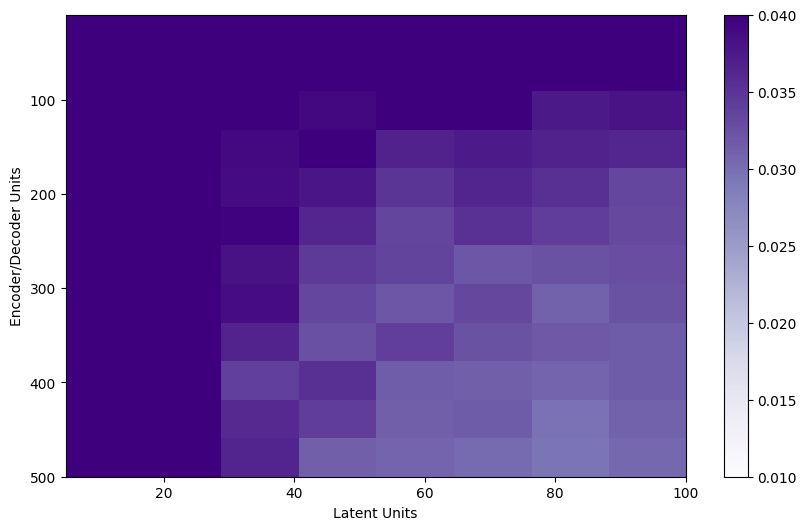

In [20]:
fig = plt.figure(figsize=(10,6))

plt.imshow(
    losses_array,
    aspect='auto',
    vmin=.01, vmax=.04,
    cmap='Purples',
    extent=[LatentUnits[0],LatentUnits[-1],EncDecUntis[-1],EncDecUntis[0]]
    )
plt.xlabel('Latent Units'),
plt.ylabel('Encoder/Decoder Units')
plt.colorbar()
plt.show();